In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime
     

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [2]:
df = pd.read_csv('apartments_for_rent_classified_100K.csv', sep = ';', encoding = 'cp1252')
df.head()
print(f"Number of records: {len(df)}")

Number of records: 99492


C:\Users\barca\AppData\Local\Temp\ipykernel_15668\2797003217.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('apartments_for_rent_classified_100K.csv', sep = ';', encoding = 'cp1252')


In [3]:
df = df[df['price_type'] == 'Monthly']
print(f"Number of records: {len(df)}")
df = df[df['category'] == 'housing/rent/apartment']
print(f"Number of records: {len(df)}")
df = df[df['fee'] == 'No']
print(f"Number of records: {len(df)}")
df = df[df['time'] != 'RentLingo']
print(f"Number of records: {len(df)}")
df.drop(columns=['title','fee','source','time','body','price_display','currency','price_type', 'category','address', 'cityname', 'state', 'pets_allowed', 'has_photo'], inplace=True)


Number of records: 99488
Number of records: 99427
Number of records: 99226
Number of records: 99226


In [4]:
df.dropna(subset=['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price'], inplace=True)
df['amenities'] = df['amenities'].fillna('')
df['amenities_count'] = df['amenities'].apply(lambda x: x.count(',')+1)
df['amenities_count'].value_counts()
df.drop(columns=['amenities'], inplace=True)
df.isnull().sum()

id                 0
bathrooms          0
bedrooms           0
price              0
square_feet        0
latitude           0
longitude          0
amenities_count    0
dtype: int64

In [5]:
print(f"Number of records: {len(df)}")

Number of records: 99020


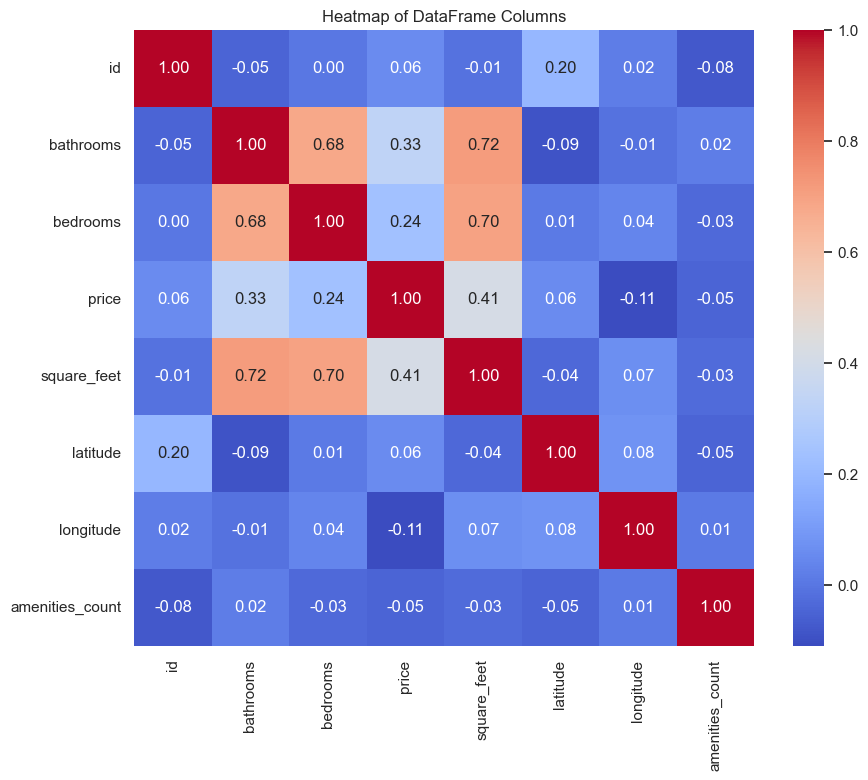

In [6]:
# Generate a heatmap for the dataframe
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of DataFrame Columns')
plt.show()

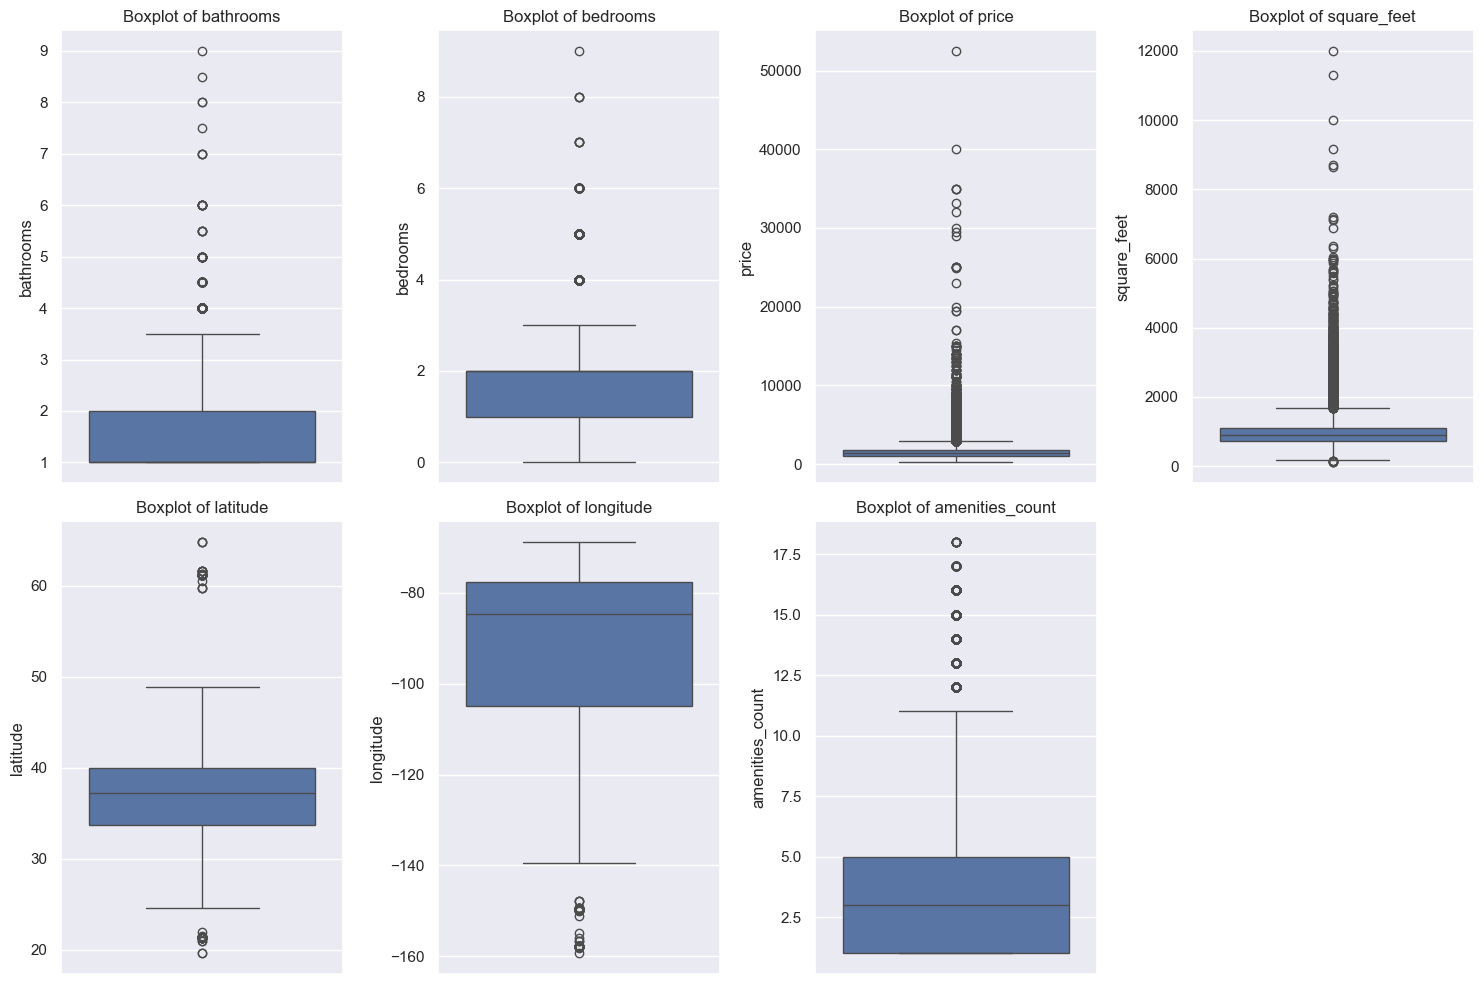

In [5]:
# Generate boxplots for each feature
features = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude', 'amenities_count']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

In [6]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]
    return df

columns_to_check = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude', 'amenities_count']
for column in columns_to_check:
    df = remove_outliers(df, column)

df.reset_index(drop=True, inplace=True)
df.head()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,amenities_count
0,5668640009,1.0,1.0,2195.0,542,33.8520,-118.3759,1
1,5668639818,1.5,3.0,1250.0,1500,37.0867,-76.4941,1
2,5668639686,2.0,3.0,1395.0,1650,35.8230,-78.6438,1
3,5668639659,1.0,2.0,1600.0,820,38.3622,-121.9712,1
4,5668639374,1.0,1.0,975.0,624,35.1038,-106.6110,1


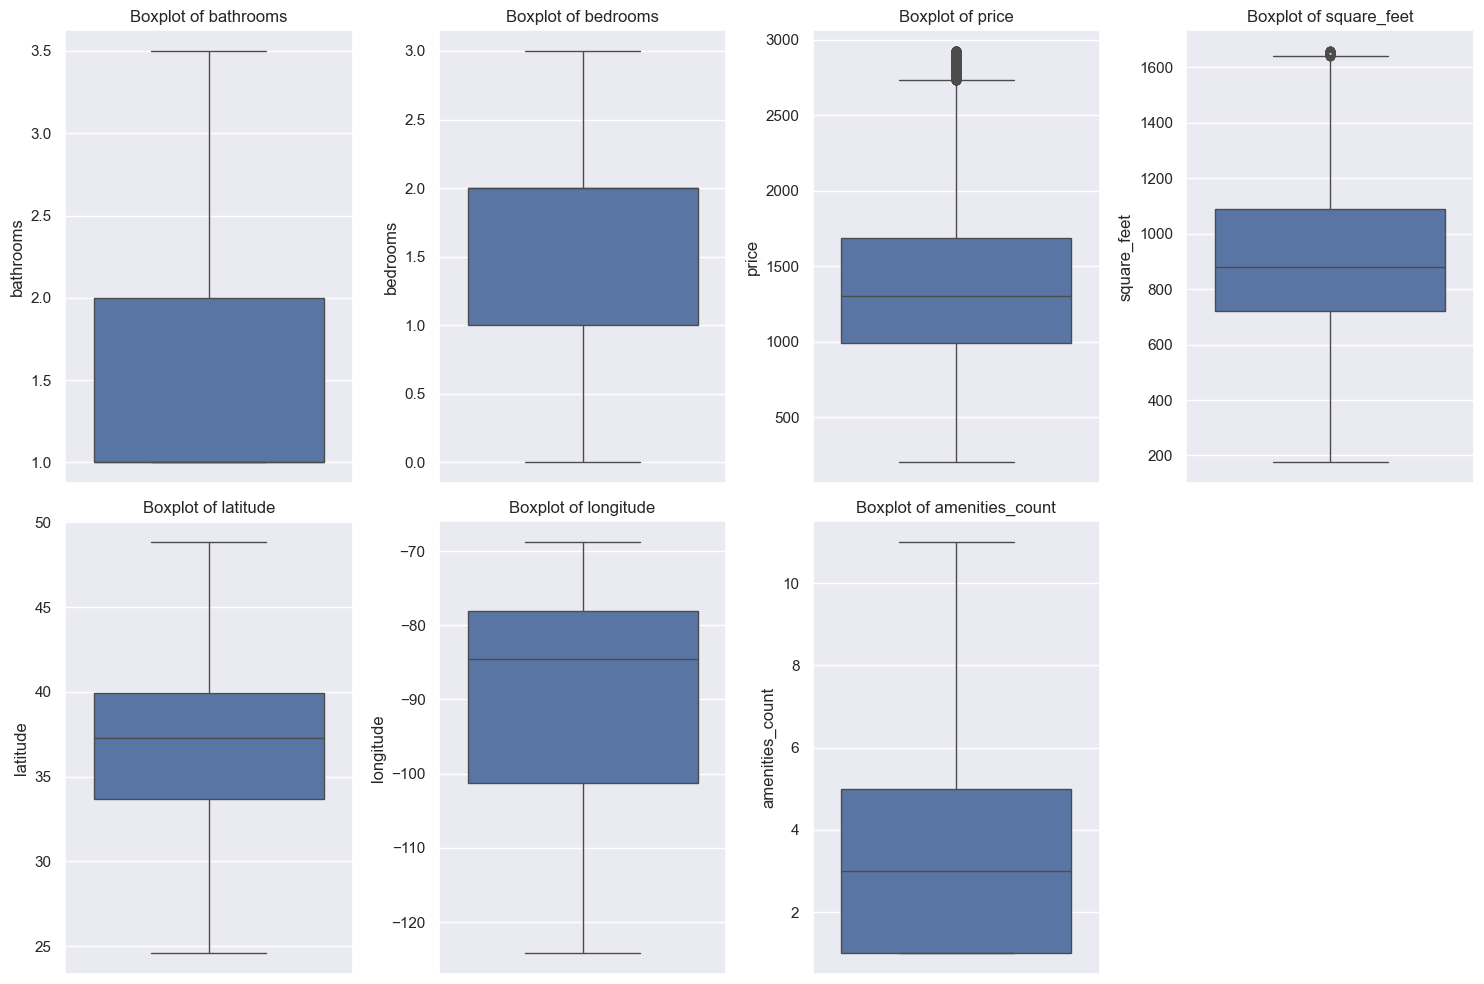

In [9]:
# Generate boxplots for each feature
features = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude', 'amenities_count']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

In [10]:
print(f"Number of records after removing outliers: {len(df)}")

Number of records after removing outliers: 87894


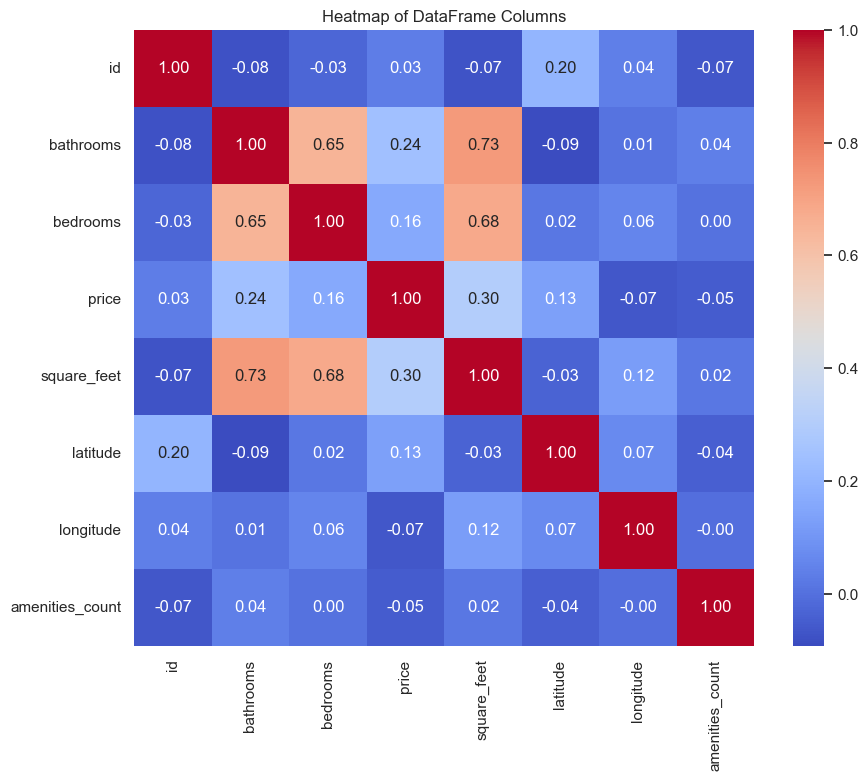

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of DataFrame Columns')
plt.show()

In [8]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Separate features and target variable
X = df.drop(columns=['price', 'id'])
y = df['price']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict the prices on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")
rmse= np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")
mae= np.mean(np.abs(y_test - y_pred))
print(f"Mean Absolute Error: {mae}")
#R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

Mean Squared Error: 40547.747413997
Root Mean Squared Error: 201.36471243491746
Mean Absolute Error: 129.49870436501774
R2 Score: 0.8489057093539352


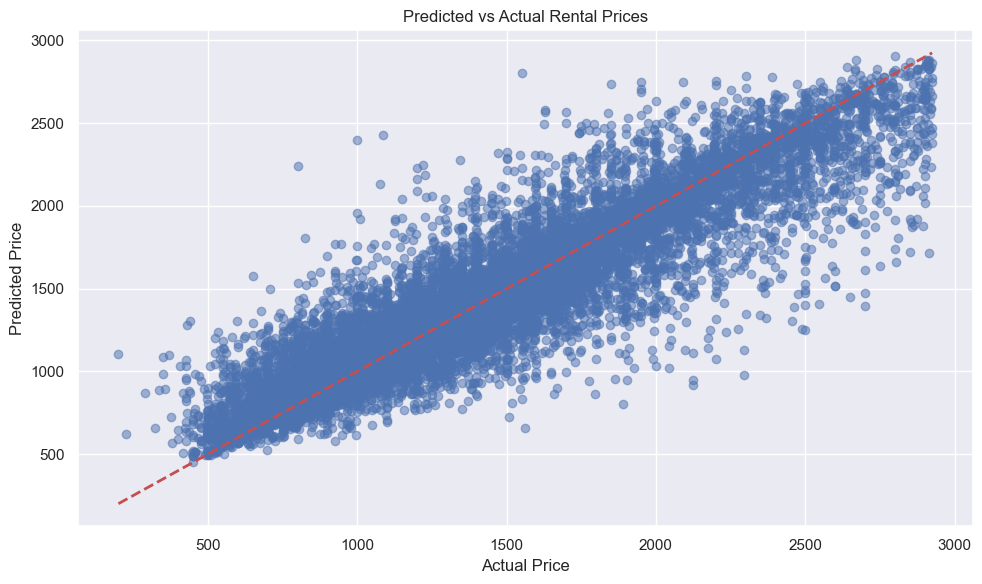

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Rental Prices')
plt.tight_layout()
plt.show()

In [ ]:
#import mse, rmse, mae, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Initialize models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'BayesianRidge': BayesianRidge(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(kernel='linear'),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

# Print results
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"MSE: {metrics['MSE']:.2f}")
    print(f"RMSE: {np.sqrt(metrics['MSE']):.2f}")
    print(f"MAE: {mae]:.2f}")
    print(f"R2: {metrics['R2']:.4f}")


Ridge:
MSE: 231382.39
RMSE: 481.02


KeyError: 'MAE'

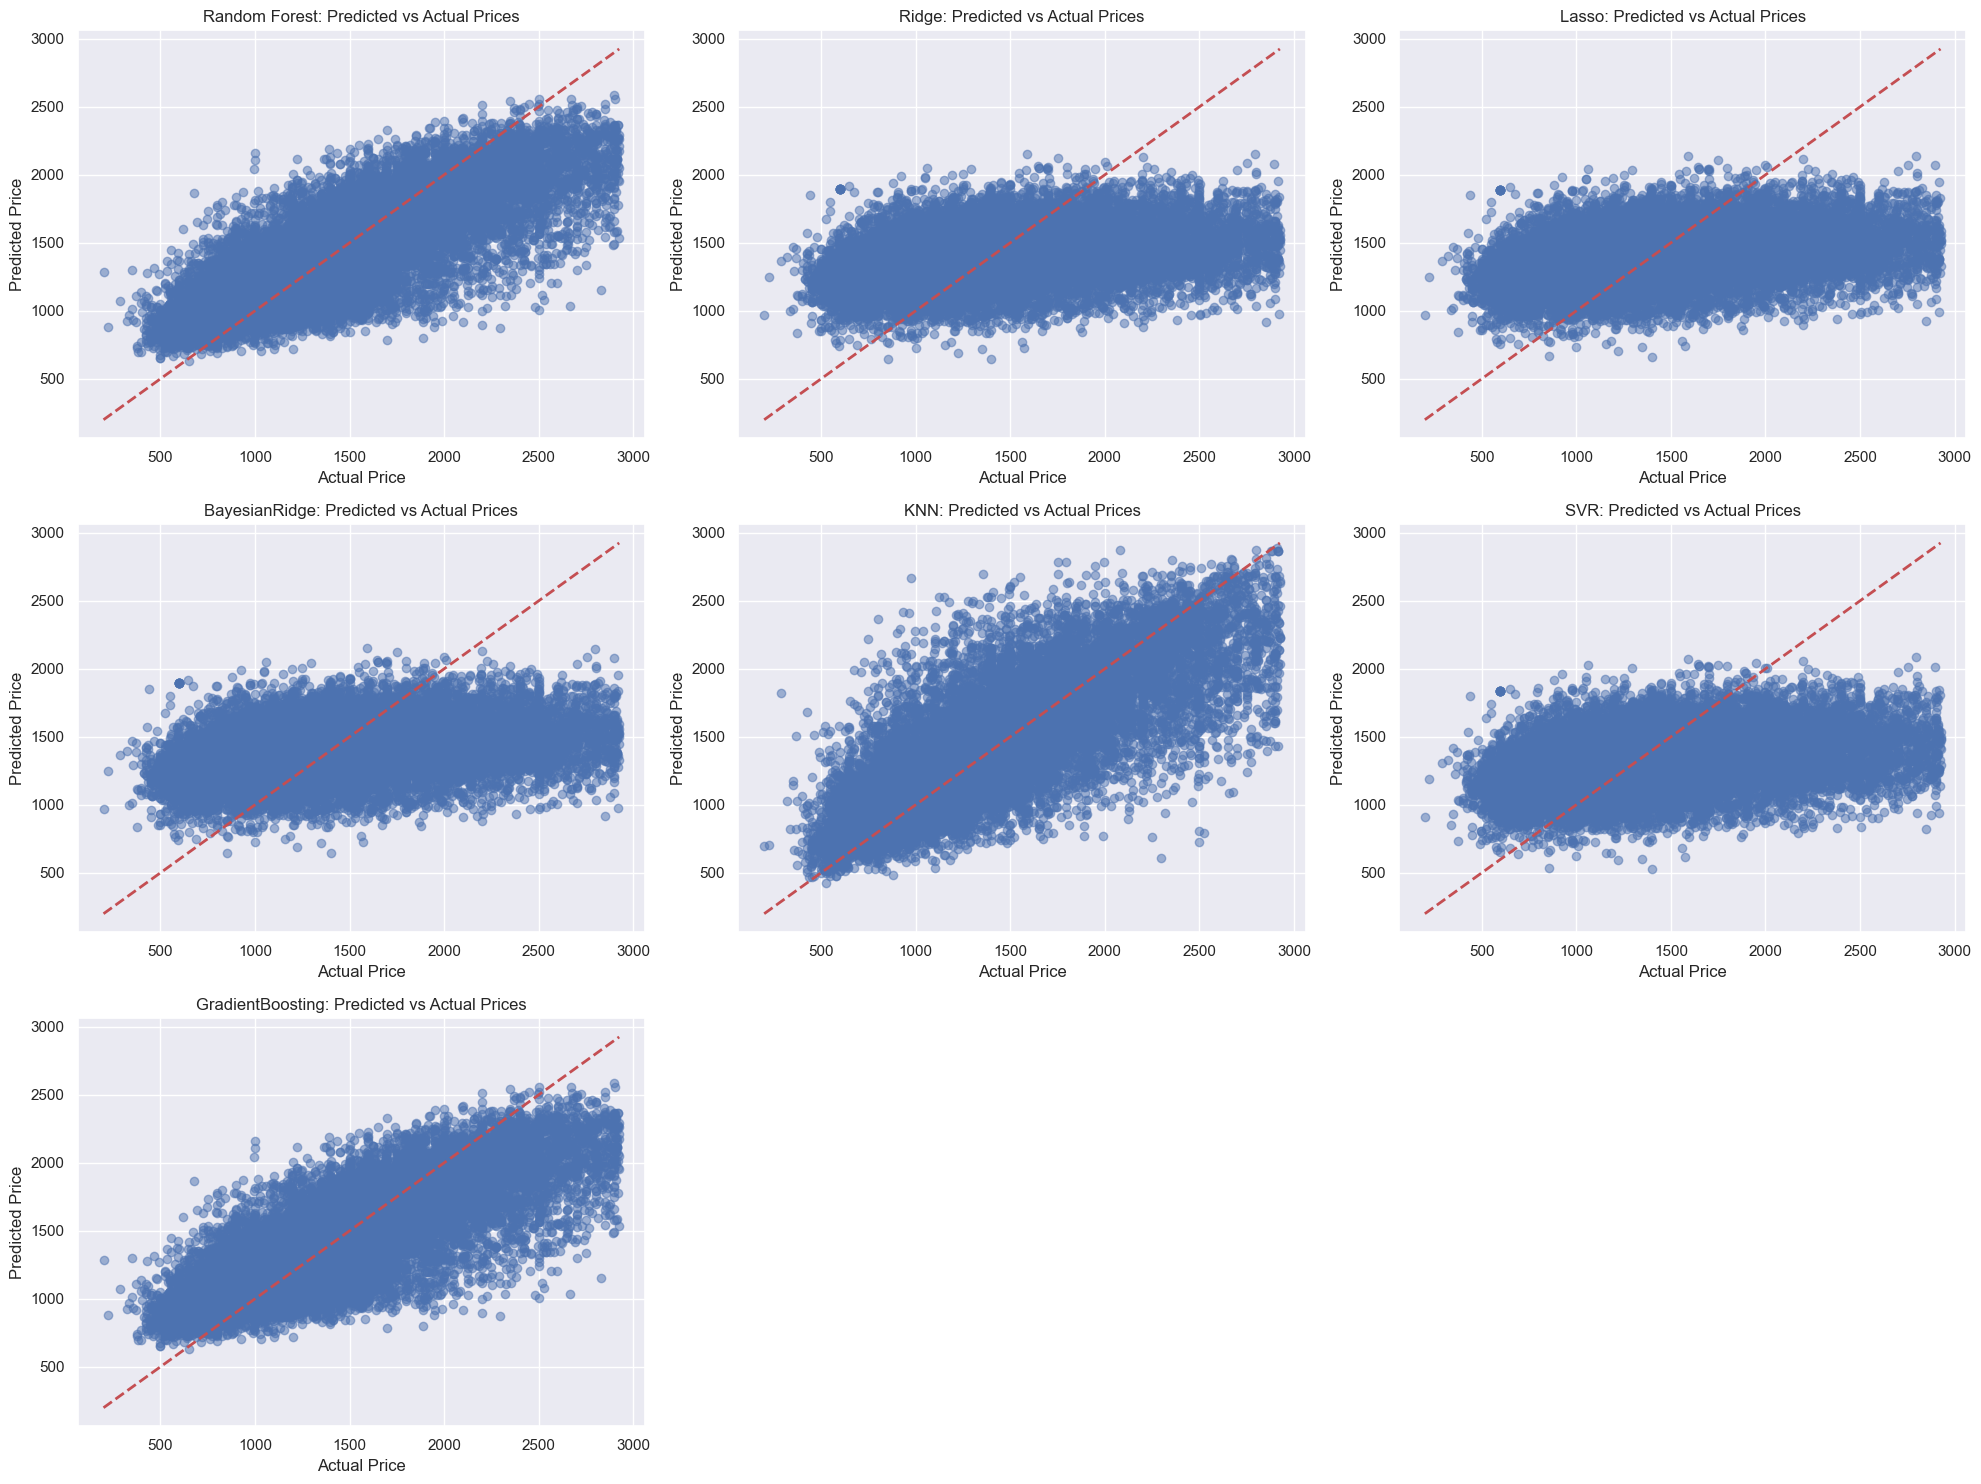

In [19]:
# Create a figure with subplots for all models
fig = plt.figure(figsize=(20, 15))
subplot_index = 1

# Plot for Random Forest (from previous cell)
plt.subplot(3, 3, subplot_index)
plt.scatter(y_test, model.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Predicted vs Actual Prices')
subplot_index += 1

# Plot for each model in results
for name, metrics in results.items():
    plt.subplot(3, 3, subplot_index)
    y_pred = models[name].predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{name}: Predicted vs Actual Prices')
    subplot_index += 1

plt.tight_layout()
plt.show()

XGBoost Results:
MSE: 56038.51
R2: 0.7914


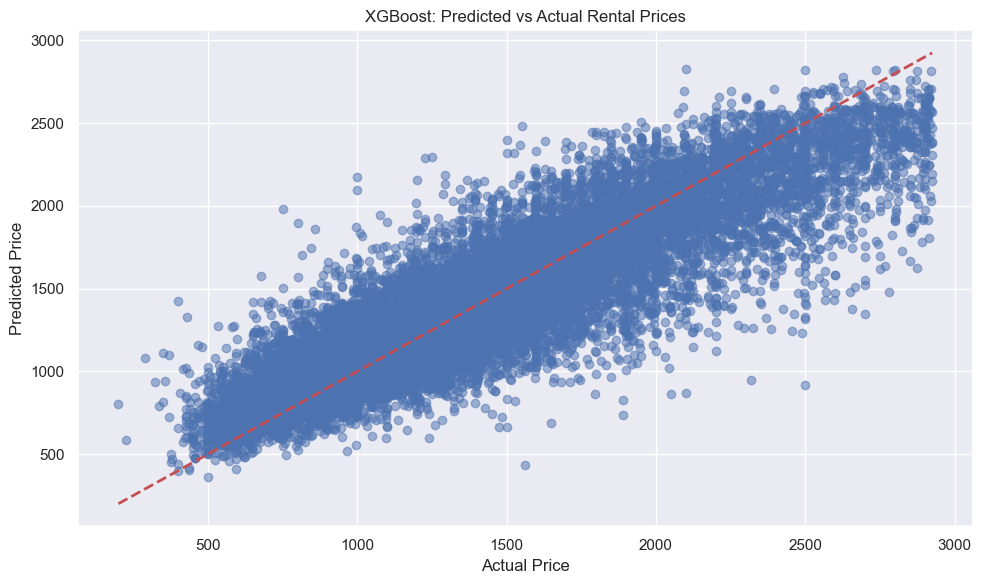

In [20]:
# Train XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

# Calculate metrics
xgb_mse = np.mean((y_test - xgb_pred) ** 2)
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost Results:")
print(f"MSE: {xgb_mse:.2f}")
print(f"R2: {xgb_r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost: Predicted vs Actual Rental Prices')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import NuSVR

# Initialize new models
new_models = {
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(random_state=42),
    'Neural_Network': MLPRegressor(random_state=42, max_iter=500),
    'Kernel_Ridge': KernelRidge(alpha=1.0),
    'NuSVR': NuSVR(kernel='rbf')
}

# Train and evaluate each new model
new_results = {}
for name, model in new_models.items():
    # Perform 5-fold cross validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    
    # Train the model on the full training set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = np.mean((y_test - y_pred) ** 2)
    r2 = r2_score(y_test, y_pred)
    
    new_results[name] = {
        'MSE': mse,
        'R2': r2,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std()
    }

# Print results
for name, metrics in new_results.items():
    print(f"\n{name}:")
    print(f"MSE: {metrics['MSE']:.2f}")
    print(f"R2: {metrics['R2']:.4f}")
    print(f"CV R2: {metrics['CV_R2_mean']:.4f} (+/- {metrics['CV_R2_std']*2:.4f})")

# Visualize predictions
plt.figure(figsize=(20, 12))
for i, (name, model) in enumerate(new_models.items(), 1):
    plt.subplot(2, 3, i)
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{name}: Predicted vs Actual Prices')

plt.tight_layout()
plt.show()

c:\Users\barca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\barca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\barca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
